# Sentiment Analysis

## Import Packages and Dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import re

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.util import ngrams

from datetime import datetime
from wordcloud import WordCloud

from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Indonesia language corpus
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

%matplotlib inline

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jayasaja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jayasaja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jayasaja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jayasaja\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
df = pd.read_csv('indo_dataset.csv')
df.head()

,label,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."


## Data Exploration and Plotting

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4401 entries, 0 to 4400
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4401 non-null   object
 1   tweet   4401 non-null   object
dtypes: object(2)
memory usage: 68.9+ KB


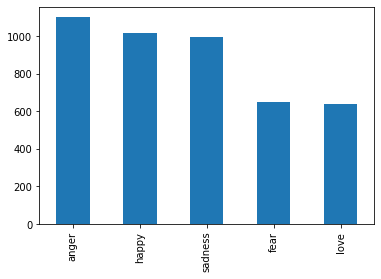

In [6]:
label = df.label.value_counts()
label.plot(kind='bar')
plt.show()

In [7]:
positive_sentiment = df[df['label'] == 'happy']
negative_sentiment = df[df['label'] == 'sadness']

dataset = positive_sentiment.append(negative_sentiment).reset_index()
dataset.head()

,index,label,tweet
0,2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
1,4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
2,6,happy,Sharing sama temen tuh emg guna bgt. Disaat lu...
3,12,happy,"sangat bersyukur bisa mendoakan kakeknya, Bung..."
4,18,happy,H-9. Mau ke bank rame bgt ampe antrian tempat ...


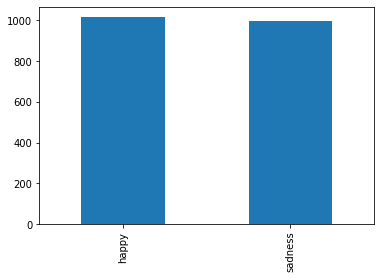

In [8]:
label = dataset.label.value_counts()
label.plot(kind='bar')
plt.show()

In [9]:
dataset['no_punctuation'] = dataset['tweet'].apply(lambda x: x.lower())
dataset.head()

,index,label,tweet,no_punctuation
0,2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj. amad foto dari go...
1,4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...","sharing pengalaman aja, kemarin jam 18.00 bata..."
2,6,happy,Sharing sama temen tuh emg guna bgt. Disaat lu...,sharing sama temen tuh emg guna bgt. disaat lu...
3,12,happy,"sangat bersyukur bisa mendoakan kakeknya, Bung...","sangat bersyukur bisa mendoakan kakeknya, bung..."
4,18,happy,H-9. Mau ke bank rame bgt ampe antrian tempat ...,h-9. mau ke bank rame bgt ampe antrian tempat ...


In [10]:
# Function to remove useless characters like 'https//.<>'

def clean(text):
  text = re.sub(re.compile(r'<.*?>'), r'', text)          
  text = re.sub(re.compile(r'https://\S+'), r'', text)    
  text = re.sub(re.compile(r'www\.\S+'), r'', text)
  text = re.sub(re.compile(r'[^\w\s]'), r'', text)        
  return text

In [11]:
dataset['no_punctuation'] = dataset['no_punctuation'].apply(lambda x : clean(x))
dataset.head()

,index,label,tweet,no_punctuation
0,2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj amad foto dari goo...
1,4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing pengalaman aja kemarin jam 1800 batali...
2,6,happy,Sharing sama temen tuh emg guna bgt. Disaat lu...,sharing sama temen tuh emg guna bgt disaat lu ...
3,12,happy,"sangat bersyukur bisa mendoakan kakeknya, Bung...",sangat bersyukur bisa mendoakan kakeknya bung ...
4,18,happy,H-9. Mau ke bank rame bgt ampe antrian tempat ...,h9 mau ke bank rame bgt ampe antrian tempat du...


In [12]:
start = datetime.now()

dataset['tokenize'] = dataset['no_punctuation'].apply(lambda x: word_tokenize(x))

end = datetime.now()

print(f'Time {end - start}')
dataset.head()

Time 0:00:00.692062


,index,label,tweet,no_punctuation,tokenize
0,2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj amad foto dari goo...,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
1,4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing pengalaman aja kemarin jam 1800 batali...,"[sharing, pengalaman, aja, kemarin, jam, 1800,..."
2,6,happy,Sharing sama temen tuh emg guna bgt. Disaat lu...,sharing sama temen tuh emg guna bgt disaat lu ...,"[sharing, sama, temen, tuh, emg, guna, bgt, di..."
3,12,happy,"sangat bersyukur bisa mendoakan kakeknya, Bung...",sangat bersyukur bisa mendoakan kakeknya bung ...,"[sangat, bersyukur, bisa, mendoakan, kakeknya,..."
4,18,happy,H-9. Mau ke bank rame bgt ampe antrian tempat ...,h9 mau ke bank rame bgt ampe antrian tempat du...,"[h9, mau, ke, bank, rame, bgt, ampe, antrian, ..."


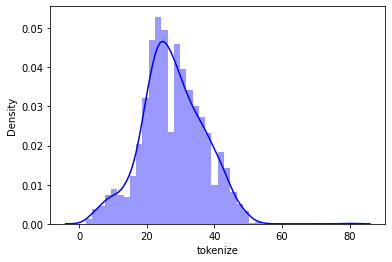

In [13]:
word_count = dataset['tokenize'].apply(lambda x :len(x))

sns. distplot(word_count, color='Blue')
plt.show();

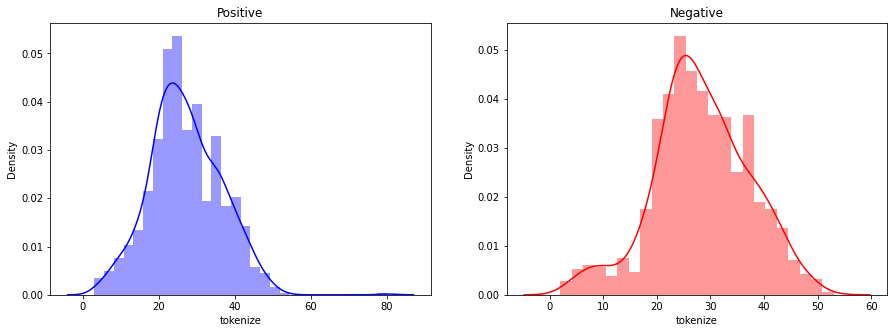

In [14]:
# we want to see our dataset words distribution

positive_tweet = dataset[dataset['label'] == 'happy']
negative_tweet = dataset[dataset['label'] == 'sadness']

count_p = positive_tweet['tokenize'].apply(lambda x:len(x))
count_n = negative_tweet['tokenize'].apply(lambda x:len(x))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
sns.distplot(count_p, ax = ax1, color = 'Blue')
ax1.set_title("Positive")
sns.distplot(count_n, ax = ax2, color='Red')
ax2.set_title("Negative")
plt.show() 

## Lemmatization
In this part, we lemmatize our dataset words. It is basically simplify some words in our dataset.<br>
<i>Note : if you run this, please skip stemming part!</i>

In [15]:
start = datetime.now()

lemmatizer = WordNetLemmatizer()
dataset['tokenize'] = dataset['tokenize'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

end = datetime.now()
print(f'Time {end-start}')
dataset.head()

Time 0:00:03.823388


,index,label,tweet,no_punctuation,tokenize
0,2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj amad foto dari goo...,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
1,4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing pengalaman aja kemarin jam 1800 batali...,"[sharing, pengalaman, aja, kemarin, jam, 1800,..."
2,6,happy,Sharing sama temen tuh emg guna bgt. Disaat lu...,sharing sama temen tuh emg guna bgt disaat lu ...,"[sharing, sama, temen, tuh, emg, guna, bgt, di..."
3,12,happy,"sangat bersyukur bisa mendoakan kakeknya, Bung...",sangat bersyukur bisa mendoakan kakeknya bung ...,"[sangat, bersyukur, bisa, mendoakan, kakeknya,..."
4,18,happy,H-9. Mau ke bank rame bgt ampe antrian tempat ...,h9 mau ke bank rame bgt ampe antrian tempat du...,"[h9, mau, ke, bank, rame, bgt, ampe, antrian, ..."


## Stemming
Same as lemmatization, stemming also simplify our words data but in an extreme way.<br>
<i>Example : username -> usernam, simple -> simpl</i>

In [16]:
start = datetime.now()

stemming = PorterStemmer()
dataset['tokenize'] = dataset['tokenize'].apply(lambda x: [stemming.stem(word) for word in x])

end = datetime.now()
print(f'Time {end-start}')
dataset.head()

## Remove Stopwords
In natural language processing stopwords only cause bad results to our model.

In [17]:
start = datetime.now()

stop = set(stopwords.words('indonesian'))
dataset['tokenize'] = dataset['tokenize'].apply(lambda x: [word for word in x if word not in stop])

end = datetime.now()
print(f'Time {end-start}')
dataset.head()

Time 0:00:00.030659


,index,label,tweet,no_punctuation,tokenize
0,2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj amad foto dari goo...,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
1,4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing pengalaman aja kemarin jam 1800 batali...,"[sharing, pengalaman, aja, kemarin, jam, 1800,..."
2,6,happy,Sharing sama temen tuh emg guna bgt. Disaat lu...,sharing sama temen tuh emg guna bgt disaat lu ...,"[sharing, temen, tuh, emg, bgt, disaat, lu, ng..."
3,12,happy,"sangat bersyukur bisa mendoakan kakeknya, Bung...",sangat bersyukur bisa mendoakan kakeknya bung ...,"[bersyukur, mendoakan, kakeknya, karno, anakan..."
4,18,happy,H-9. Mau ke bank rame bgt ampe antrian tempat ...,h9 mau ke bank rame bgt ampe antrian tempat du...,"[h9, bank, rame, bgt, ampe, antrian, duduknya,..."


In [18]:
dataset['tweet_proceed'] = dataset['tokenize'].apply(lambda x: " ".join(x))
dataset.head()

,index,label,tweet,no_punctuation,tokenize,tweet_proceed
0,2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj amad foto dari goo...,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ...",kepingin gudeg mbarek bu hj amad foto google s...
1,4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing pengalaman aja kemarin jam 1800 batali...,"[sharing, pengalaman, aja, kemarin, jam, 1800,...",sharing pengalaman aja kemarin jam 1800 batali...
2,6,happy,Sharing sama temen tuh emg guna bgt. Disaat lu...,sharing sama temen tuh emg guna bgt disaat lu ...,"[sharing, temen, tuh, emg, bgt, disaat, lu, ng...",sharing temen tuh emg bgt disaat lu ngerasa lu...
3,12,happy,"sangat bersyukur bisa mendoakan kakeknya, Bung...",sangat bersyukur bisa mendoakan kakeknya bung ...,"[bersyukur, mendoakan, kakeknya, karno, anakan...",bersyukur mendoakan kakeknya karno anakanak ya...
4,18,happy,H-9. Mau ke bank rame bgt ampe antrian tempat ...,h9 mau ke bank rame bgt ampe antrian tempat du...,"[h9, bank, rame, bgt, ampe, antrian, duduknya,...",h9 bank rame bgt ampe antrian duduknya diluar ...


## Create WordCloud
Plotting every single words in our dataset.

In [19]:
def display(tweet):
  plt.subplots(figsize = (8, 8))
  word = WordCloud(width = 500,
                   height = 300,
                   max_words = 2000,
                   random_state = 42,
                   background_color = 'white',
                   collocations = False)
  word.generate(' '.join(tweet))
  plt.imshow(word)
  plt.axis('off')
  plt.show()

In [20]:
positive_tweet = dataset[dataset['label'] == 'happy']
negative_tweet = dataset[dataset['label'] == 'sadness']

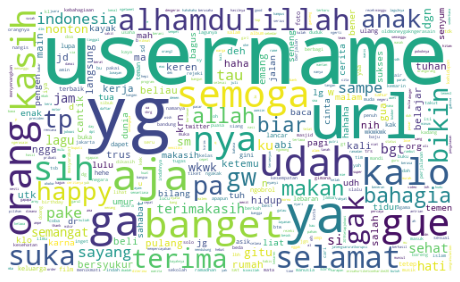

In [21]:
display(positive_tweet['tweet_proceed'])

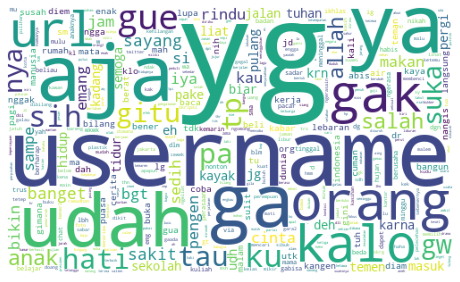

In [22]:
display(negative_tweet['tweet_proceed'])

## Encode Label
Turning our label from string to numeric.

In [23]:
label = LabelEncoder()

dataset['label'] = dataset[['label']].apply(lambda x: label.fit_transform(x))
dataset.head()

,index,label,tweet,no_punctuation,tokenize,tweet_proceed
0,2,0,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj amad foto dari goo...,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ...",kepingin gudeg mbarek bu hj amad foto google s...
1,4,0,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing pengalaman aja kemarin jam 1800 batali...,"[sharing, pengalaman, aja, kemarin, jam, 1800,...",sharing pengalaman aja kemarin jam 1800 batali...
2,6,0,Sharing sama temen tuh emg guna bgt. Disaat lu...,sharing sama temen tuh emg guna bgt disaat lu ...,"[sharing, temen, tuh, emg, bgt, disaat, lu, ng...",sharing temen tuh emg bgt disaat lu ngerasa lu...
3,12,0,"sangat bersyukur bisa mendoakan kakeknya, Bung...",sangat bersyukur bisa mendoakan kakeknya bung ...,"[bersyukur, mendoakan, kakeknya, karno, anakan...",bersyukur mendoakan kakeknya karno anakanak ya...
4,18,0,H-9. Mau ke bank rame bgt ampe antrian tempat ...,h9 mau ke bank rame bgt ampe antrian tempat du...,"[h9, bank, rame, bgt, ampe, antrian, duduknya,...",h9 bank rame bgt ampe antrian duduknya diluar ...


## Data Overview
Showing differences between column in our recent data.

In [24]:
print('1. [Tweet]', dataset['tweet'][0], '\n')
print('2. [no_punctuation]', dataset['no_punctuation'][0], '\n')
print('3. [tokenize]', dataset['tokenize'][0], '\n')
print('4. [tweet_proceed]', dataset['tweet_proceed'][0], '\n')

1. [Tweet] Kepingin gudeg mbarek Bu hj. Amad Foto dari google, sengaja, biar teman-teman jg membayangkannya. Berbagi itu indah. 

2. [no_punctuation] kepingin gudeg mbarek bu hj amad foto dari google sengaja biar temanteman jg membayangkannya berbagi itu indah 

3. [tokenize] ['kepingin', 'gudeg', 'mbarek', 'bu', 'hj', 'amad', 'foto', 'google', 'sengaja', 'biar', 'temanteman', 'jg', 'membayangkannya', 'berbagi', 'indah'] 

4. [tweet_proceed] kepingin gudeg mbarek bu hj amad foto google sengaja biar temanteman jg membayangkannya berbagi indah 



## Vectorizer
Turning our words data into a vector, so that we can procced to our machine learning model.

In [25]:
vect = TfidfVectorizer().fit_transform(dataset['tweet_proceed'].values.tolist())
vect.shape

(2014, 11718)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(vect, 
                                                    dataset['label'], 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [27]:
# prediction without n_gram

model = MultinomialNB()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

print(f'Accuracy: {round(accuracy_score(y_test, prediction), 3)}')

Accuracy: 0.737


## Predict using n_gram
n_gram is basically a sequence of N word.

In [28]:
vect = TfidfVectorizer(ngram_range=(1,3)).fit_transform(dataset['tweet_proceed'].values.tolist())
vect.shape

(2014, 74360)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(vect, 
                                                    dataset['label'], 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [30]:
model = MultinomialNB()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

print(f'Accuracy: {round(accuracy_score(y_test, prediction), 3)}')

Accuracy: 0.734


## Recommendations

* To improve our model we can manually remove some words that is not essential and also concluded in positive_tweet and negative_tweet.

---

* In this notebook, if you use lemmatization our model will be slightly better on model without n_gram otherwise (if you choose stemming) it will be better on n_gram model.

---

For more about stemming and lemmatization, go watch this.<br>
https://www.youtube.com/watch?v=JpxCt3kvbLk